In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

RANDOM_SEED = 42

%matplotlib inline


In [2]:
def load_data():
    df_train = pd.read_csv('./data/train.csv')
    df_test = pd.read_csv('./data/test.csv')
    return df_train, df_test

df_train, df_test = load_data()

In [3]:
print (df_train.shape)
print (df_test.shape)

(1458644, 11)
(625134, 9)


In [4]:
df_train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [5]:
df_test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


<br>
# Check if the train & test is unique ID <br>


In [6]:
print('Train and test sets are Unique.') if len(np.intersect1d(df_train['id'].values, df_test['id'].values))== 0 else print('Not Unique')

Train and test sets are Unique.


In [7]:
for col in df_train.columns:
    print ("Col name : "+col, len(df_train[col].unique()))

Col name : id 1458644
Col name : vendor_id 2
Col name : pickup_datetime 1380222
Col name : dropoff_datetime 1380377
Col name : passenger_count 10
Col name : pickup_longitude 23047
Col name : pickup_latitude 45245
Col name : dropoff_longitude 33821
Col name : dropoff_latitude 62519
Col name : store_and_fwd_flag 2
Col name : trip_duration 7417


# Check the Data <br>

In [8]:
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
for col in df_train.columns:
    print ("Col name : "+col, df_train[col].dtypes)

Col name : id object
Col name : vendor_id int64
Col name : pickup_datetime object
Col name : dropoff_datetime object
Col name : passenger_count int64
Col name : pickup_longitude float64
Col name : pickup_latitude float64
Col name : dropoff_longitude float64
Col name : dropoff_latitude float64
Col name : store_and_fwd_flag object
Col name : trip_duration int64


In [10]:
for col in df_train.columns:
    print (col, len(df_train[col].unique()))

id 1458644
vendor_id 2
pickup_datetime 1380222
dropoff_datetime 1380377
passenger_count 10
pickup_longitude 23047
pickup_latitude 45245
dropoff_longitude 33821
dropoff_latitude 62519
store_and_fwd_flag 2
trip_duration 7417


# 1. Add Feature 
# (1) Change the type of Date then add 'pick up date' feature 
# (2) Add Time feature

In [11]:
def pre_processing(df, train=True):
    df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
    df['pickup_date'] = df['pickup_datetime'].dt.date
#    df['dist'] = np.log(1+10*np.sqrt(np.square(df['pickup_longitude']-df['dropoff_longitude'])+np.square(df['pickup_latitude']-df['dropoff_latitude'])))
    if train : 
        df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
        df['check_trip_duration'] = (df['dropoff_datetime']-df['pickup_datetime']).map(lambda x: x.total_seconds())
        df['log_trip'] = np.log(df['trip_duration'].values+1)
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'Y':1, 'N':0})
    
    ## Time Processing 
    df['pick_weekday'] = df['pickup_datetime'].dt.weekday
    df['pick_weekofyear'] = df['pickup_datetime'].dt.weekofyear
    df['pick_hour'] = df['pickup_datetime'].dt.hour
    df['pick_min'] = df['pickup_datetime'].dt.minute
    df['pick_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
    df['pick_week_hour'] = df['pick_weekday']*24+df['pick_hour']
    
    return df

In [12]:
df_train = pre_processing(df_train, train=True)
df_test = pre_processing(df_test, train=False)
df_train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip,pick_weekday,pick_weekofyear,pick_hour,pick_min,pick_dt,pick_week_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016-03-14,455.0,6.122493,0,11,17,24,6369878.0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016-06-12,663.0,6.498282,6,23,0,43,14085798.0,144
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016-01-19,2124.0,7.661527,1,3,11,35,1596907.0,35


(array([  3.30000000e+01,   0.00000000e+00,   1.77000000e+02,
          0.00000000e+00,   3.18000000e+02,   0.00000000e+00,
          3.17000000e+02,   2.84000000e+02,   1.92000000e+02,
          2.18000000e+02,   2.06000000e+02,   4.21000000e+02,
          1.64000000e+02,   3.14000000e+02,   4.50000000e+02,
          2.77000000e+02,   5.24000000e+02,   4.02000000e+02,
          4.85000000e+02,   6.11000000e+02,   5.53000000e+02,
          8.32000000e+02,   9.16000000e+02,   1.43000000e+03,
          1.69300000e+03,   2.84800000e+03,   4.24500000e+03,
          6.00800000e+03,   8.77800000e+03,   1.29630000e+04,
          1.89590000e+04,   2.64870000e+04,   3.55110000e+04,
          4.50130000e+04,   5.88140000e+04,   6.89740000e+04,
          8.24950000e+04,   9.34350000e+04,   1.03080000e+05,
          1.11102000e+05,   1.12725000e+05,   1.12528000e+05,
          1.07650000e+05,   9.74220000e+04,   8.52740000e+04,
          7.07090000e+04,   5.56630000e+04,   4.15460000e+04,
        

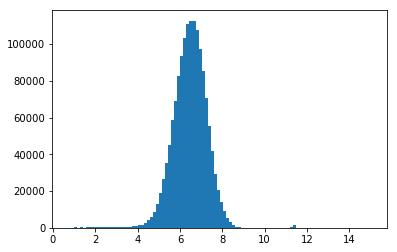

In [13]:
plt.hist(df_train['log_trip'].values, bins=100)


In [14]:
print (df_train['pickup_date'].max(), df_train['pickup_date'].min())
print (df_test['pickup_date'].max(), df_test['pickup_date'].min())
print (df_train['pickup_longitude'].max(), df_train['pickup_longitude'].min())
print (df_test['pickup_longitude'].max(), df_test['pickup_longitude'].min())
print (df_train['pickup_latitude'].max(), df_train['pickup_latitude'].min())
print (df_test['pickup_latitude'].max(), df_test['pickup_latitude'].min())
print (df_train['dropoff_longitude'].max(), df_train['dropoff_longitude'].min())
print (df_test['dropoff_longitude'].max(), df_test['dropoff_longitude'].min())
print (df_train['dropoff_latitude'].max(), df_train['dropoff_latitude'].min())
print (df_test['dropoff_latitude'].max(), df_test['dropoff_latitude'].min())

2016-06-30 2016-01-01
2016-06-30 2016-01-01
-61.3355293274 -121.93334198
-69.248916626 -121.933128357
51.8810844421 34.3596954346
42.8149375916 37.3895874023
-61.3355293274 -121.933303833
-67.4967956543 -121.933326721
43.9210281372 32.1811408997
48.8575973511 36.6013221741


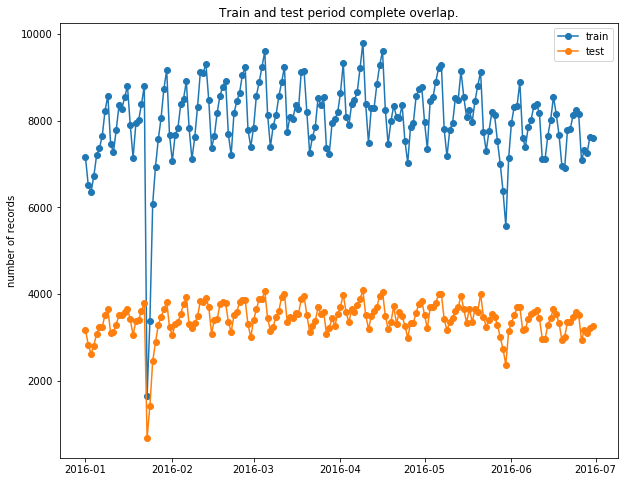

In [15]:
plt.figure(figsize=(10,8))
plt.plot(df_train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(df_test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

<br>The lowest pick-up call date is <br>

In [16]:
df_train.groupby('pickup_date').count()[['id']].idxmin()

id    2016-01-23
dtype: object

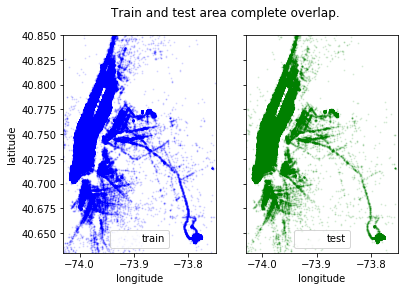

In [17]:
def show_pickup_location(df_train):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
    ax[0].scatter(df_train['pickup_longitude'].values, df_train['pickup_latitude'].values,
                  color='blue', s=1, label='train', alpha=0.1)
    ax[1].scatter(df_test['pickup_longitude'].values, df_test['pickup_latitude'].values,
                  color='green', s=1, label='test', alpha=0.1)
    fig.suptitle('Train and test area complete overlap.')
    ax[0].legend(loc=0)
    ax[0].set_ylabel('latitude')
    ax[0].set_xlabel('longitude')
    ax[1].set_xlabel('longitude')
    ax[1].legend(loc=0)
    plt.ylim(city_lat_border)
    plt.xlim(city_long_border)
    plt.show() 
    
show_pickup_location(df_train)

In [18]:
def pca_transform(df_train, df_test):
    
    from sklearn.decomposition import PCA
    
    coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))
    
    pca = PCA()
    
    print (pca)
    pca.fit(coords)
    
    df_train['pickup_pca0'] = pca.transform(df_train[['pickup_latitude', 'pickup_longitude']])[:, 0]
    df_train['pickup_pca1'] = pca.transform(df_train[['pickup_latitude', 'pickup_longitude']])[:, 1]
    df_train['dropoff_pca0'] = pca.transform(df_train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    df_train['dropoff_pca1'] = pca.transform(df_train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    df_test['pickup_pca0'] = pca.transform(df_test[['pickup_latitude', 'pickup_longitude']])[:, 0]
    df_test['pickup_pca1'] = pca.transform(df_test[['pickup_latitude', 'pickup_longitude']])[:, 1]
    df_test['dropoff_pca0'] = pca.transform(df_test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    df_test['dropoff_pca1'] = pca.transform(df_test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    
    return df_train, df_test

In [19]:
df_train, df_test = pca_transform(df_train, df_test)
df_train.head(3)

    

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip,pick_weekday,pick_weekofyear,pick_hour,pick_min,pick_dt,pick_week_hour,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016-03-14,455.0,6.122493,0,11,17,24,6369878.0,17,0.007691,0.017053,-0.009666,0.013695
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016-06-12,663.0,6.498282,6,23,0,43,14085798.0,144,0.007677,-0.012371,0.027145,-0.018652
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016-01-19,2124.0,7.661527,1,3,11,35,1596907.0,35,0.004803,0.012879,0.034222,-0.039337


In [20]:
df_train['pickup_pca0'].describe()

count    1.458644e+06
mean     3.560932e-05
std      7.084957e-02
min     -1.244609e+01
25%     -7.260550e-03
50%      7.727282e-03
75%      1.890063e-02
max      4.807449e+01
Name: pickup_pca0, dtype: float64

In [21]:
city_lat_border = (df_train['pickup_pca0'].describe()['25%'], df_train['pickup_pca0'].describe()['75%'])

In [22]:
df_train['pickup_pca1'].describe()

count    1.458644e+06
mean    -4.414311e-04
std      3.299371e-02
min     -6.857210e+00
25%     -1.295075e-02
50%      3.063014e-03
75%      1.588978e-02
max      1.104230e+01
Name: pickup_pca1, dtype: float64

In [23]:
city_long_border = (df_train['pickup_pca1'].describe()['25%'], df_train['pickup_pca1'].describe()['75%'])

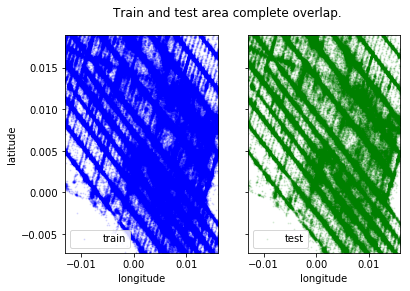

In [24]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_pca1'].values, df_train['pickup_pca0'].values,
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_test['pickup_pca1'].values, df_test['pickup_pca0'].values,
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show() 

In [25]:
def haversine_dist(lat1, long1, lat2, long2):
    
    
    lat1, long1, lat2, long2 = map(np.radians, (lat1, long1, lat2, long2))
    
    earth_r = 6371  # km 
    
    delta_lat = lat2 - lat1
    delta_long = long2 - long1
    
    a = np.sin(delta_lat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(delta_long/2.0)**2
    
    dist = 2* earth_r * np.arcsin(np.sqrt(a))
    
    return dist 

def pitagorian_square_dist(lat1, long1, lat2, long2):
    
    return (haversine_dist(lat1, long1, lat1, long2)+haversine_dist(lat1, long1, lat2, long1))

In [26]:
def feature_engineering(df, train=True):
    df['h_dist'] = haversine_dist(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df['square_dist'] = pitagorian_square_dist(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    
    df['center_latitude'] = (df['pickup_latitude'].values + df['dropoff_latitude'].values) / 2
    df['center_longitude'] = (df['pickup_longitude'].values + df['dropoff_longitude'].values) / 2

    if train : 
        df['avg_speed_kmh'] = df['h_dist'] / (df['trip_duration']/3600.0)
        df['avg_speed_square_kmh'] = df['square_dist'] / (df['trip_duration']/3600.0)
    
    return df

df_train = feature_engineering(df_train, train=True)
df_test = feature_engineering(df_test, train=False)

In [27]:
df_train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip,pick_weekday,pick_weekofyear,pick_hour,pick_min,pick_dt,pick_week_hour,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,h_dist,square_dist,center_latitude,center_longitude,avg_speed_kmh,avg_speed_square_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016-03-14,455.0,6.122493,0,11,17,24,6369878.0,17,0.007691,0.017053,-0.009666,0.013695,1.498521,1.735433,40.766769,-73.973392,11.856428,13.730901
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016-06-12,663.0,6.498282,6,23,0,43,14085798.0,144,0.007677,-0.012371,0.027145,-0.018652,1.805507,2.430506,40.734858,-73.989948,9.803659,13.197318
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016-01-19,2124.0,7.661527,1,3,11,35,1596907.0,35,0.004803,0.012879,0.034222,-0.039337,6.385098,8.203575,40.737013,-73.992180,10.822201,13.904365


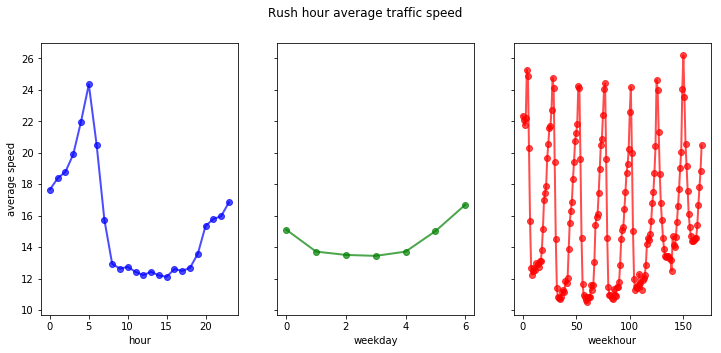

In [28]:
#fig = plt.figure(figsize=(8,10))
fig, ax = plt.subplots(figsize=(12,5), ncols=3, sharey=True)
ax[0].plot(df_train.groupby('pick_hour').mean()['avg_speed_kmh'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(df_train.groupby('pick_weekday').mean()['avg_speed_kmh'], 'go-', lw=2, alpha=0.7)
ax[2].plot(df_train.groupby('pick_week_hour').mean()['avg_speed_kmh'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [30]:
X = df_train[['pick_weekday', 'pick_weekofyear', 'pick_hour', 'pick_min',
             'pick_dt', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'h_dist']]
y = df_train['log_trip']

In [31]:
X.head(3)

,pick_weekday,pick_weekofyear,pick_hour,pick_min,pick_dt,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,h_dist
0,0,11,17,24,6369878.0,0.007691,0.017053,-0.009666,0.013695,1.498521
1,6,23,0,43,14085798.0,0.007677,-0.012371,0.027145,-0.018652,1.805507
2,1,3,11,35,1596907.0,0.004803,0.012879,0.034222,-0.039337,6.385098


In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [36]:
logit_clf = LogisticRegression()
rf_clf = RandomForestRegressor(random_state=42)
svr_clf = SVR(kernel='rbf')

In [37]:
scores = cross_val_score(rf_clf, X_train_scaled, y_train,
                         scoring="neg_mean_squared_error", cv=10,  n_jobs=-1, verbose = 1 )
cross_val_scores = np.sqrt(-scores)
cross_val_scores

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  4.3min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.5min finished


array([ 0.41861182,  0.42288019,  0.42847302,  0.43264532,  0.42703263,
        0.42898718,  0.43545589,  0.43075701,  0.42824281,  0.42700484])

In [38]:
np.mean(y_train)

6.466982938342501

In [39]:
error = cross_val_scores / np.mean(y_train)

In [40]:
error

array([ 0.06473062,  0.06539065,  0.06625547,  0.06690064,  0.06603274,
        0.06633498,  0.06733525,  0.06660865,  0.06621988,  0.06602845])

In [42]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
]



In [46]:
grid_search = GridSearchCV(rf_clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1, verbose = 1)

In [47]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 24.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

# Total error of Validation 

In [51]:
np.sqrt(-grid_search.score(X_valid_scaled, y_valid))

0.40850864679393784

In [52]:
grid_search.best_params_


{'max_features': 4, 'n_estimators': 30}

In [53]:
y_valid_predicted = grid_search.predict(X_valid_scaled)

In [54]:
df_valid = pd.DataFrame(index=y_valid.index)


In [55]:
df_valid['label'] = y_valid
df_valid['prediced'] = y_valid_predicted
df_valid.head()

,label,prediced
67250,6.947937,6.626020
1397036,6.719013,6.652119
1021087,6.421622,5.843581
951424,6.766192,6.854675
707882,8.510773,8.531622


In [63]:
df_valid.head(30)

,label,prediced
67250,6.947937,6.626020
1397036,6.719013,6.652119
1021087,6.421622,5.843581
951424,6.766192,6.854675
707882,8.510773,8.531622
1432685,5.926926,5.904884
528407,7.133296,6.480567
1217989,5.003946,5.194985
1165122,7.313220,7.240809
1324437,6.925595,6.809279


In [64]:
X_submit = df_test[['pick_weekday', 'pick_weekofyear', 'pick_hour', 'pick_min',
             'pick_dt', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'h_dist']]

In [65]:
X_submit_scaled = scaler.transform(X_submit)

In [66]:
y_submit_predicted = grid_search.predict(X_submit_scaled)

In [67]:
df_submit = pd.read_csv('./data/sample_submission.csv')

In [68]:
df_submit.head(3)

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959


In [71]:
df_submit['trip_duration'] = np.exp(y_submit_predicted)

In [73]:
df_submit.to_csv('./data/output.csv', index=False)